In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import rcParams
import matplotlib.pyplot as plt
import h5py
import os
import tqdm
import scipy
from scipy import signal
from tqdm import tnrange
import seaborn as sns
from scipy.stats import norm,entropy,linregress
from scipy.optimize import minimize, curve_fit
from scipy.io import savemat
import multiprocess as mp
from multiprocess import Pool
from scipy.special import erf
import sys
import warnings
warnings.filterwarnings('ignore')

cmap = plt.rcParams['axes.prop_cycle'].by_key()['color']
modulename = 'multiprocess'

mpl.rcParams['svg.fonttype'] = 'none'
sns.set_context('poster', font_scale=1.1)

warnings.filterwarnings('ignore')

cmap = plt.rcParams['axes.prop_cycle'].by_key()['color']
modulename = 'multiprocess'

mpl.rcParams['svg.fonttype'] = 'none'
sns.set_context('poster', font_scale=1.1)

from odor_breathing_functions import*
from functions_beh import*

path = os.getcwd() + '/Session/'
savepath = os.getcwd() + '/Figures/test/'
savepath_pdf = os.getcwd() + '/Figures/test/pdf/'
savepath_png = os.getcwd() + '/Figures/test/png/'
savepath_svg = os.getcwd() + '/Figures/test/svg/'

#dir_list = os.listdir(path)
#np_savepath = os.getcwd() + '/Other_outputs/MLE_arrays/'

In [11]:
# Compute psychometrics of each animal
results_list=list()

animal_list = [['Banner'],
               ['Natasha'],
               ['Stark'],
               ['Peterparker']]

for animals in animal_list:
    fname_list = list()
    for date_number in range(20220127,20220526):    
        for animal in animals:
            for session_id in range(0,10):
                session_string = str(session_id)
                date_string = str(date_number)
                fname = animal + '_' + date_string + '_' + session_string + '.pickle'
                cell_fname = path + 'session_' + fname
                if os.path.isfile(cell_fname):
                    fname_list.append(fname)

    for i_file in tnrange(len(fname_list)):
        
        session_id = 0
        fname = fname_list[i_file]
        sfname = fname[:-7]
        date_name = sfname[-10:-2]
        #print(fname, sfname, date_name)
        session_fname = path + 'session_' + fname
        if os.path.isfile(session_fname):
            with open(session_fname,'rb') as handle:
                session_list = pickle.load(handle)
                session = session_list[0]
                num_trials = session['num_trials']

                interval = int(session_list[0]['delay_time']*1000)
                non_idle_trials = np.invert(session['idle_trials'])[:num_trials]
                correct_trials = session['correct_trials'][:num_trials][non_idle_trials]
                high_trials = session['high_trials'][:num_trials][non_idle_trials]
                low_trials = session['low_trials'][:num_trials][non_idle_trials]
                delayt = np.repeat(interval, num_trials)[non_idle_trials]
                sess_id = np.repeat(fname[:-7], num_trials)[non_idle_trials]
                trial_type = np.repeat(session_list[0]['type'], num_trials)[non_idle_trials]
                lambda_1 = np.repeat(session_list[0]['high_count'], num_trials)[non_idle_trials]
                lambda_2 = np.repeat(session_list[0]['low_count'], num_trials)[non_idle_trials]
                ratio = np.repeat(round(session_list[0]['high_count']/session_list[0]['low_count']), num_trials)[non_idle_trials]
                high_choices = (correct_trials==high_trials)
                trial_odor = session['trial_odor'][:num_trials][non_idle_trials][0:interval]
                cum_odor = np.ceil(trial_odor.sum(axis=1)/(50*100))
                breathing_signal = np.append(session['trial_pre_breath'][:num_trials][non_idle_trials, -2500:],
                                     session['trial_breath'][:num_trials][non_idle_trials, :interval+1500], axis=1)
                
                #sniff_hist = get_sniff_histogram(session,False)[:num_trials][non_idle_trials]
                
                high_seven = cum_odor>8
                low_eight = cum_odor<=8
                bad_trials_1 = np.logical_and(high_seven,low_trials)
                bad_trials_2 = np.logical_and(low_eight,high_trials)
                bad_trials = np.logical_or(bad_trials_1,bad_trials_2)
                good_trials = np.invert(bad_trials)

                all_lambda_1 = lambda_1[good_trials]
                all_lambda_2 = lambda_2[good_trials]
                all_delayt = delayt[good_trials]
                all_ratios = ratio[good_trials]
                all_trial_type = trial_type[good_trials]
                all_correct_trials = correct_trials[good_trials]
                all_high_trials = high_trials[good_trials]
                all_low_trials = low_trials[good_trials]
                all_high_choices = high_choices[good_trials]
                all_cum_odor = cum_odor[good_trials]
                all_trial_odor = trial_odor[good_trials,:]
                all_breathing = breathing_signal[good_trials,:]

                for trial in range(len(all_correct_trials)):
                    result_row_1 = {'Animal': animals[0],
                'Session': sfname,
                'Date': int(date_name),
                'Trial': trial,
                'Trial_type': all_trial_type[trial].astype(str),
                'Window': all_delayt[trial].astype(int),
                'Lambda1': all_lambda_1[trial].astype(float),
                'Lambda2': all_lambda_2[trial].astype(float),
                'Total_pulse': all_cum_odor[trial].astype(int),
                'High_trial': all_high_trials[trial].astype(int),
                'High_choice': all_high_choices[trial].astype(int),
                'Correct': all_correct_trials[trial].astype(int),
                'Trial_odor': all_trial_odor[trial].flatten().tolist(),
                #'Sniff histogram': sniff_hist[trial].flatten().tolist(),
                #'Breathing': all_breathing[trial].flatten().tolist(),
                }
                
                    results_list.append(result_row_1)

df_all = pd.DataFrame(results_list)
                
           
    


  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

In [25]:
df_banner = df_all.loc[(df_all['Animal']=='Banner')&(df_all['Date']<20220327)]
df_natasha = df_all.loc[(df_all['Animal']=='Natasha')&(df_all['Date']<20220327)]
df_stark = df_all.loc[(df_all['Animal']=='Stark')&(df_all['Date']<20220327)]
df_pp = df_all.loc[(df_all['Animal']=='Peterparker')&(df_all['Date']<20220408)]

df_learning = pd.concat([df_banner, df_natasha, df_stark, df_pp])
df_learning['Train_or_test'] = np.where(
    (df_learning['Trial_type']=='random') & (df_learning['Window']==5000) & (np.round(df_learning['Lambda1']/df_learning['Lambda2'])==3),
    'testing', 'training'
)

col = df_learning.pop('Train_or_test')
df_learning.insert(5, 'Train_or_test', col)
df_learning.to_csv('df_learning.csv', index=False)

In [8]:
df_learning.to_pickle('df_learning.pkl')#, index=False)
print(len(df_learning))



36608


In [6]:
data_dict = df_learning.to_dict(orient="list")
scipy.io.savemat('learning_data.mat', data_dict)

print(data_dict['Breathing'][0])

[2.7443368635374035, 2.710819075667406, 2.672144710917025, 2.640238364694187, 2.6176783244544994, 2.60929888147108, 2.624446336305926, 2.614455461734395, 2.6186451832788666, 2.6067205913803964, 2.5793262608492205, 2.590606278931342, 2.547419926794441, 2.539685058554598, 2.5674016708696477, 2.5744919675444344, 2.5164804552840607, 2.486507845927589, 2.4729718299754624, 2.487152418134004, 2.554832509084927, 2.662153834372145, 2.793646694741446, 2.898712121615258, 3.012479340929559, 3.132370071299476, 3.2396916683562726, 3.345079595765227, 3.4443441144999607, 3.543608681611729, 3.609355370036349, 3.611289096496788, 3.6225691678940763, 3.5916295450311666, 3.5423195310754565, 3.5046118815598217, 3.469804826738669, 3.448211564254874, 3.4253291542720294, 3.4134045190996307, 3.406314195812678, 3.4188834054439248, 3.430485753480824, 3.4614253514723257, 3.4833409029010105, 3.502033580996808, 3.5284611633352925, 3.5284611633352925, 3.516536522093562, 3.474639139549886, 3.453690451533482, 3.4291966

In [35]:
#df_new = pd.read_csv('df_learning.csv')
df_new_pickle = pd.read_pickle('df_learning.pkl')
print(len(df_new_pickle['Breathing'][0]))

5000


: 

In [32]:
print(len(df_new['Breathing'][0]))

98197


In [22]:
df_block = df_all.loc[df_all['Trial_type']=='block']
df_block

,Animal,Session,Date,Trial,Trial_type,Window,Lambda1,Lambda2,Total_pulse,High_trial,High_choice,Correct,Trial_odor,Breathing
0,Banner,Banner_20220201_0,20220201,0,block,1000,16.129032,1.001001,2,0,0,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2.7443368635374035, 2.710819075667406, 2.6721..."
1,Banner,Banner_20220201_0,20220201,1,block,1000,16.129032,1.001001,2,0,0,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.4641693881401364, 0.48801841467291707, 0.48..."
2,Banner,Banner_20220201_0,20220201,2,block,1000,16.129032,1.001001,1,0,0,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.8155090299202237, 1.4332788884141867, 1.009..."
3,Banner,Banner_20220201_0,20220201,3,block,1000,16.129032,1.001001,1,0,0,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.4841999096302918, 1.4974135936290913, 1.529..."
4,Banner,Banner_20220201_0,20220201,4,block,1000,16.129032,1.001001,1,0,0,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.30786160736935037, 0.30463876702963344, 0.3..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70126,Peterparker,Peterparker_20220418_0,20220418,251,block,10000,12.300123,4.100041,4,0,0,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.30915074351075983, 0.2898137017201533, 0.30..."
70127,Peterparker,Peterparker_20220418_0,20220418,252,block,10000,12.300123,4.100041,1,0,1,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3.4936541043948743, 3.4507898641323074, 3.392..."
70128,Peterparker,Peterparker_20220418_0,20220418,253,block,10000,12.300123,4.100041,5,0,1,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3.319618898966326, 3.423073142159089, 3.50847..."
70129,Peterparker,Peterparker_20220418_0,20220418,254,block,10000,12.300123,4.100041,10,1,0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.3739784683725969, 1.1329094732207348, 0.906..."


In [17]:
pool_correct_trials = np.zeros((0,))
pool_high_choices = np.zeros((0,))
pool_cum_odor = np.zeros((0,))
for i in range(len(all_correct_trials_list)):
    pool_correct_trials = np.append(pool_correct_trials,all_correct_trials_list[i])
    pool_high_choices = np.append(pool_high_choices,all_high_choices_list[i])
    pool_cum_odor = np.append(pool_cum_odor,all_cum_odor_list[i])

phigh = np.zeros((num_bins,2))
performance = np.zeros((num_bins,2))
bin_counts = np.zeros((num_bins,))
pulse_bin_ind = np.ceil(pool_cum_odor).astype(np.int)

for i in range(num_bins):
    selected = pool_high_choices[pulse_bin_ind==pulse_bins[i]]
    selected_correct = pool_correct_trials[pulse_bin_ind==pulse_bins[i]]
    num_selected = len(selected)
    bin_counts[i] = num_selected
    phigh[i,0] = selected.mean()
    phigh[i,1] = 1.96*selected.std()/np.sqrt(num_selected)
    performance[i,0] = selected_correct.mean()
    performance[i,1] = 1.96*selected_correct.std()/np.sqrt(num_selected)

In [82]:
results_list=list()

for i in range(len(all_correct_trials_list)):
    for j in range(len(all_correct_trials_list[i])):

        result_row_1 = {'Animal': i,
                'Session': all_session_id_list[i][j],
                'Trial_type': all_trial_type_list[i][j],
                'Ratio': all_ratios_list[i][j].astype(int),
                'Window': all_delay_times_list[i][j].astype(int),
                'Total Pulse': all_cum_odor_list[i][j].astype(int),
                'Correct': all_correct_trials_list[i][j].astype(int),
                'High Choice': all_high_choices_list[i][j].astype(int)}
        
        results_list.append(result_row_1)

df_test = pd.DataFrame(results_list)
#df_test['Burstiness'] = (df_test['CV']>1).astype(int)
df_test['new_session_id'] = df_test.groupby('Animal')['Session'].rank(method='dense').astype(int)
#df_test['new_session_id'] = df_test['new_session_id'].astype('category')


#df_test.to_csv('behavioral_data_for_Farhad_corrected.csv', index=False)
df_block =df_test.loc[df_test['Trial_type']=='block']
df_random =df_test.loc[df_test['Trial_type']=='random']

In [109]:
prep_times = [1000, 2000, 3000, 4000, 5000]

df_random_1000 = df_random.loc[(df_random['Window']==1000) & (df_random['Ratio']>2)]
df_random_1000['new_session_id_norm'] = df_random_1000.groupby(['Animal', 'Ratio'])['new_session_id'].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
#df_random_1000['new_session_id_norm'] = df_random_1000['new_session_id_norm'].astype('category')
#df_random_1000[100:150]


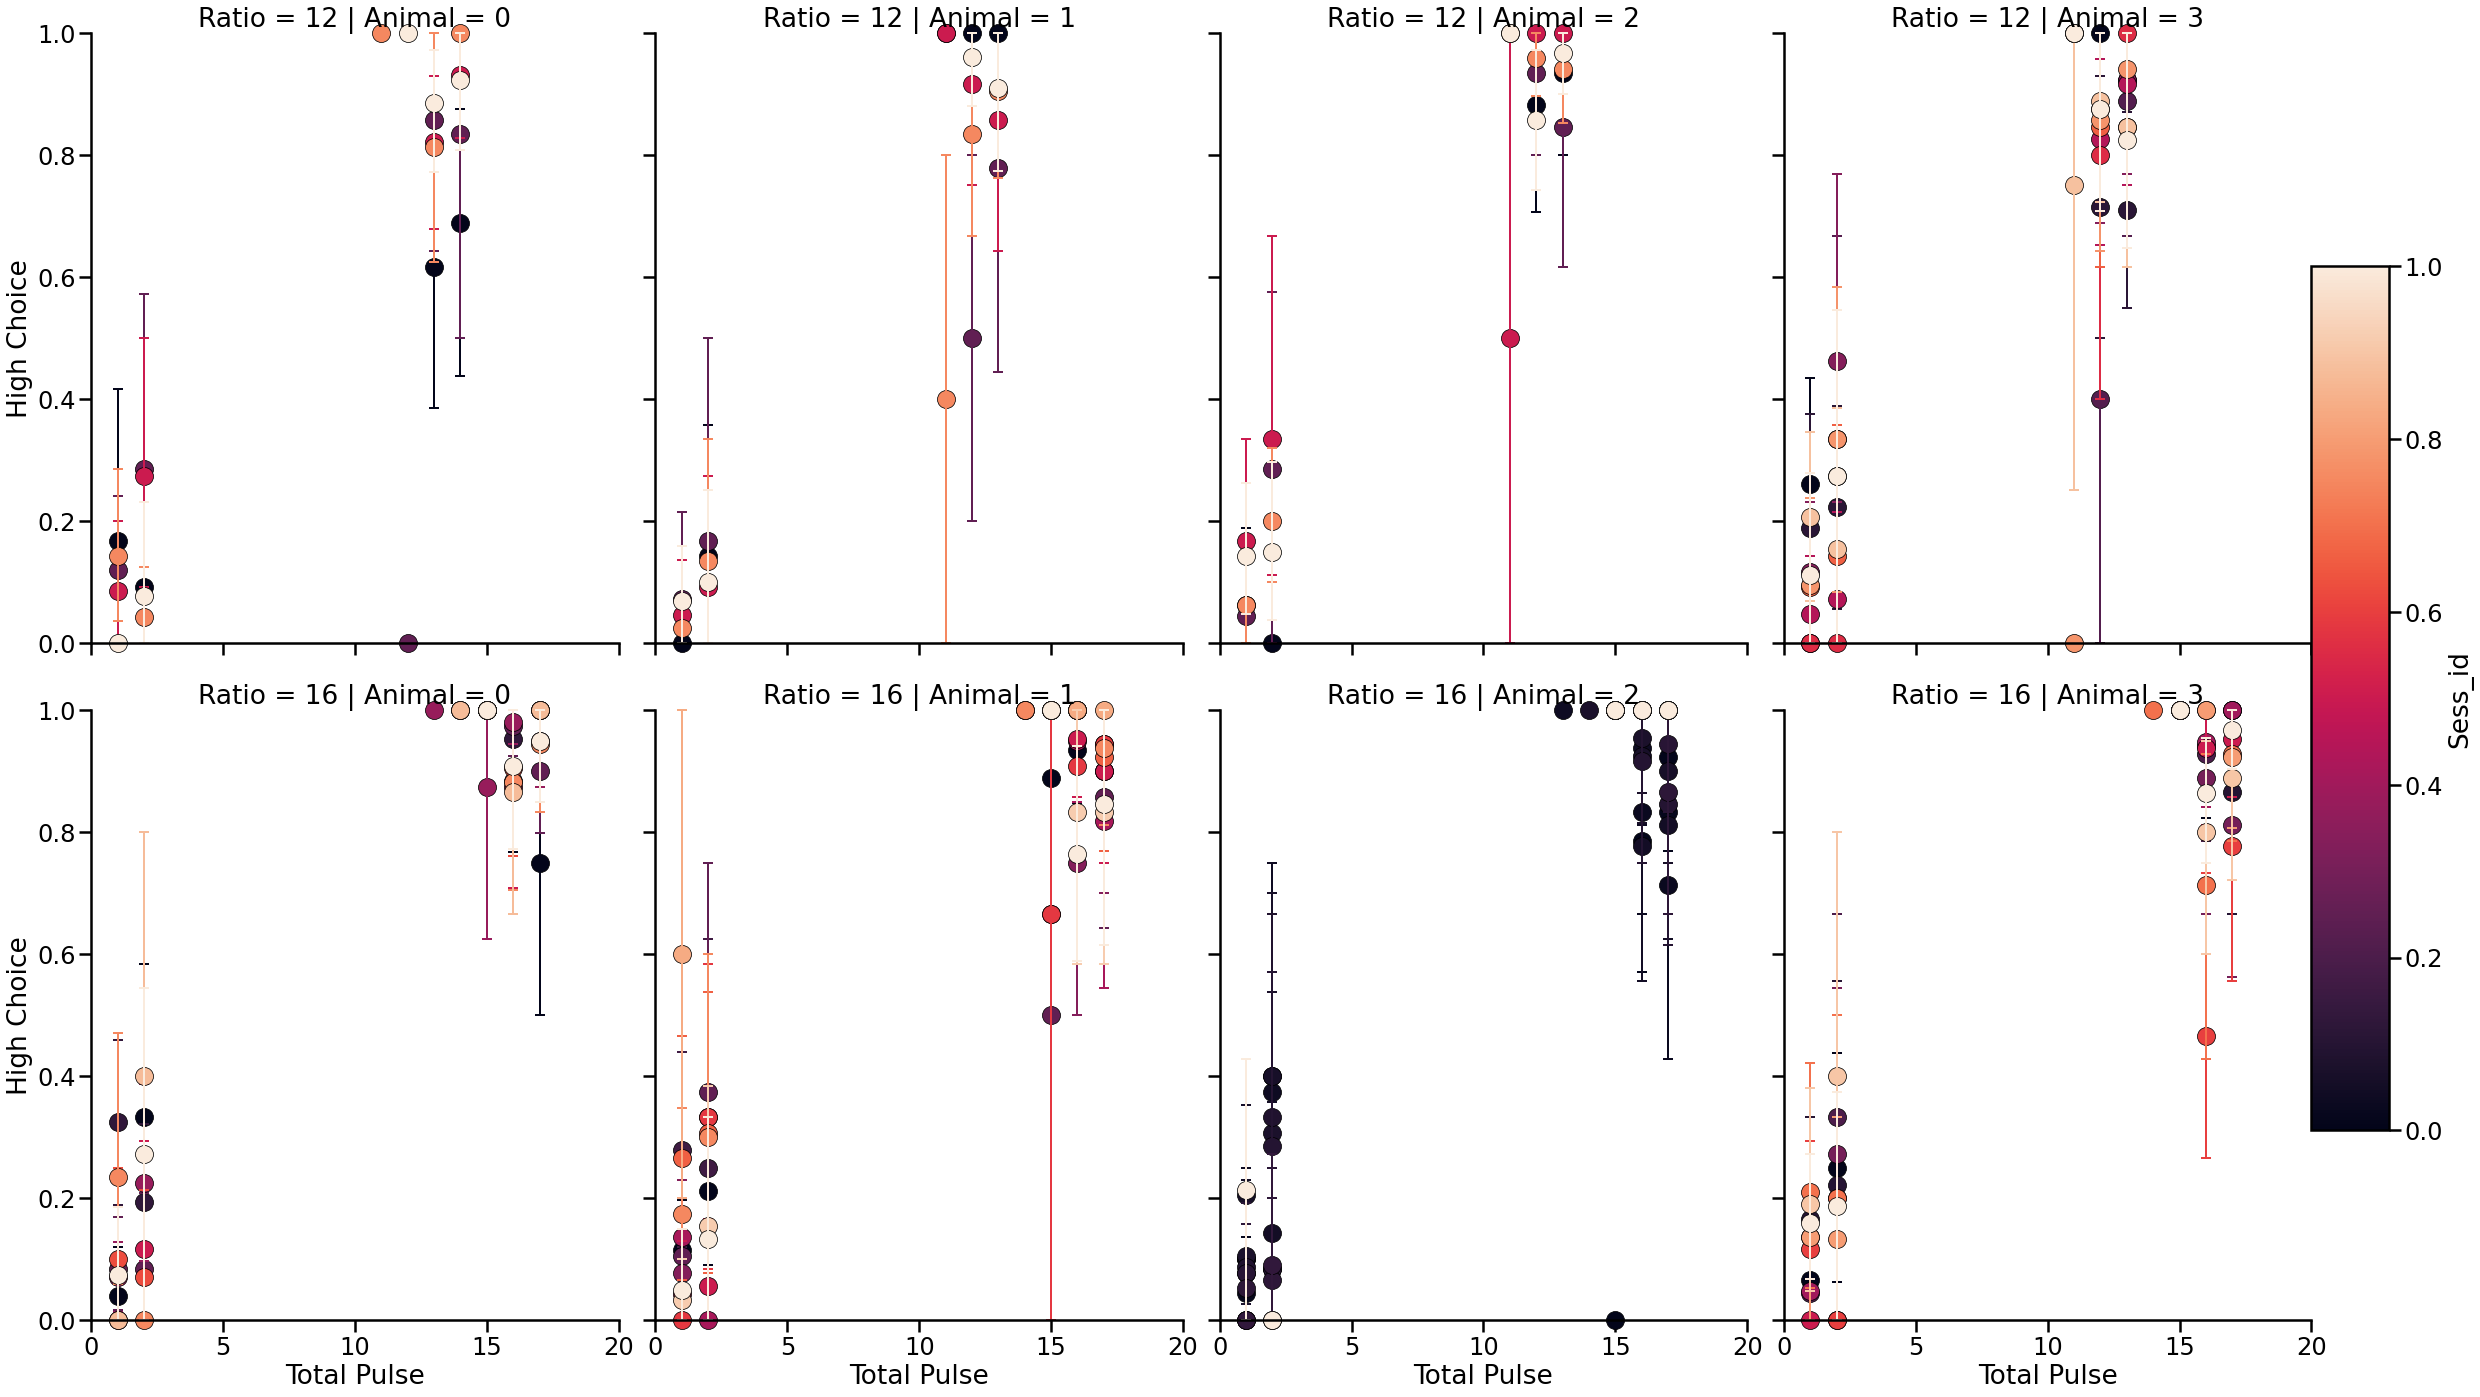

In [112]:


g = sns.FacetGrid(df_random_1000, row='Ratio', col='Animal', height=10, aspect=0.9)
g.map_dataframe(sns.lineplot, 'Total Pulse', 'High Choice', hue='new_session_id_norm', palette='rocket',
      linewidth=0, marker="o", dashes=False, markersize=18, markeredgecolor='k', err_style='bars', clip_on=False,
      err_kws={'capsize':5,'capthick':2,'elinewidth':2,'clip_on':False})

norm = mpl.colors.Normalize(vmin=df_random_1000['new_session_id_norm'].min(),
                            vmax= df_random_1000['new_session_id_norm'].max())
sm = plt.cm.ScalarMappable(cmap='rocket', norm=norm)
sm.set_array([])
cbar_ax = g.fig.add_axes([0.9,0.2,0.03,0.6])
cbar = g.fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('Sess_id')

for ax in g.axes.flat:
    ax.set_xlim(0,20)
    ax.set_ylim(0,1)

    plt.subplots_adjust(right=0.9)

In [14]:
df_banner = df_all.loc[(df_all['Animal']=='Banner')&(df_all['Date']<20220327)]
df_natasha = df_all.loc[(df_all['Animal']=='Natasha')&(df_all['Date']<20220327)]
df_stark = df_all.loc[(df_all['Animal']=='Stark')&(df_all['Date']<20220327)]
df_pp = df_all.loc[(df_all['Animal']=='Peterparker')&(df_all['Date']<20220408)]

In [107]:
df_stark["Session_num"] = df_stark["Session"].astype("category").cat.codes + 1
df_stark["Date_num"] = df_stark["Date"].astype("category").cat.codes + 1
df_stark['Ratio'] = np.round(df_stark['Lambda1']/df_stark['Lambda2'])

df_banner["Session_num"] = df_banner["Session"].astype("category").cat.codes + 1
df_banner["Date_num"] = df_banner["Date"].astype("category").cat.codes + 1
df_banner['Ratio'] = np.round(df_banner['Lambda1']/df_banner['Lambda2'])

df_natasha["Session_num"] = df_natasha["Session"].astype("category").cat.codes + 1
df_natasha["Date_num"] = df_natasha["Date"].astype("category").cat.codes + 1
df_natasha['Ratio'] = np.round(df_natasha['Lambda1']/df_natasha['Lambda2'])

df_pp["Session_num"] = df_pp["Session"].astype("category").cat.codes + 1
df_pp["Date_num"] = df_pp["Date"].astype("category").cat.codes + 1
df_pp['Ratio'] = np.round(df_pp['Lambda1']/df_pp['Lambda2'])

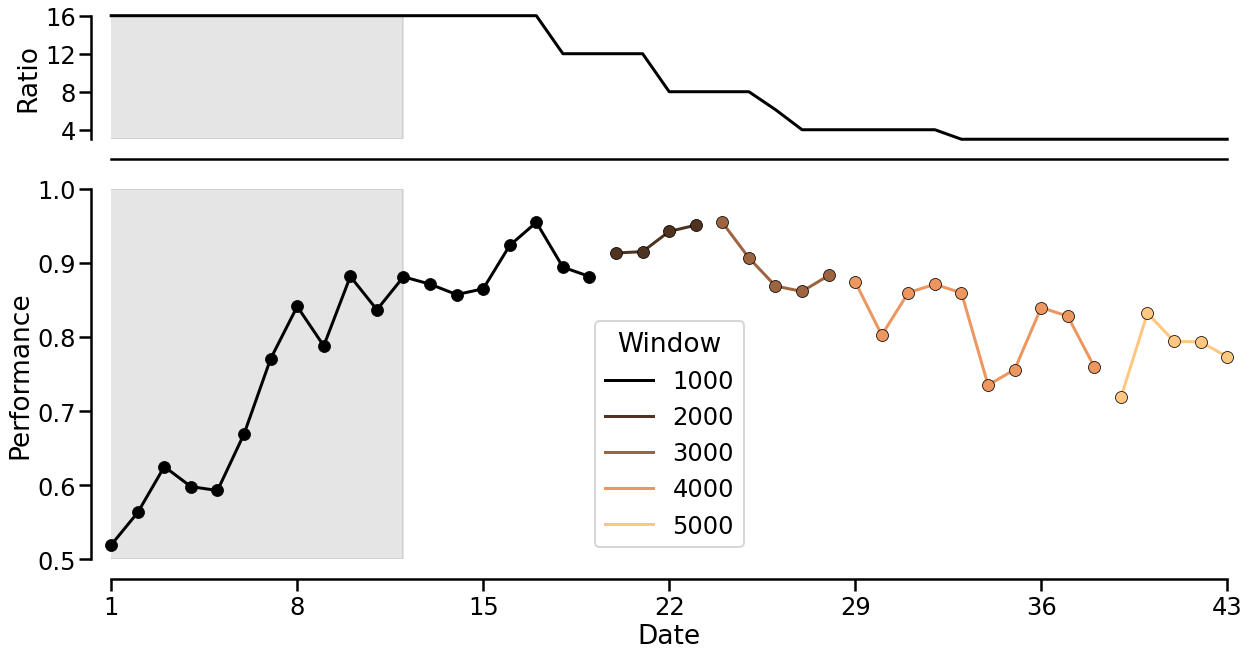

In [165]:
fig, axes = plt.subplots(2, 1, figsize=(20, 10), sharex=True, gridspec_kw={'height_ratios': [1, 3]})

sns.lineplot(data=df_stark, x='Date_num', y='Ratio', errorbar=None, ax=axes[0], color='k', clip_on=False)

axes[0].axvspan(0, 12, color="gray", alpha=0.2)   # sessions 1–4
axes[0].set_ylim(3,16)
axes[0].set_xlim(1,43)

axes[0].set_yticks([4,8,12,16])
axes[0].set_ylabel('Ratio')
# Remove top plot x-axis
#axes[0].set_xlabel("")
# Hide top plot x-axis completely
axes[0].tick_params(labelbottom=False, bottom=False)
axes[0].spines['bottom'].set_visible(False)



sns.lineplot(data=df_stark, x='Date_num', y='Correct', hue='Window', errorbar=None, marker='o', palette='copper',
             ax=axes[1], legend=True, markeredgecolor='k', clip_on=False)
axes[1].axvspan(0, 12, color="gray", alpha=0.2)   # sessions 1–4
#ax.axvspan(4.5, 7.5, color="lightblue", alpha=0.2)  # sessions 5–7
axes[1].set_xticks(np.arange(1,44,7))  # set the tick positions
axes[1].set_xlabel("Date")           # optional label
axes[1].set_ylabel("Performance")           # optional label
axes[1].spines['top'].set_visible(False)
axes[1].set_ylim(0.5,1)
axes[1].set_xlim(1,43)
sns.despine(offset=20)

plt.savefig('learning_curve_stark.svg', format='svg', bbox_inches='tight', transparent='true')
plt.savefig('learning_curve_stark.png', format='png', bbox_inches='tight', transparent='true')
plt.savefig('learning_curve_stark.pdf', format='pdf', bbox_inches='tight', transparent='true')

plt.show()



In [105]:
df_all["Session_num"] = df_all["Session"].astype("category").cat.codes + 1
df_all["Date_num"] = df_all["Date"].astype("category").cat.codes + 1

df_all['Date_num'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 60, 61, 62, 63, 64, 65, 66, 68, 69, 70,
       72, 73, 74, 75, 76, 77, 78, 79, 59, 67, 71, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90], dtype=int8)

In [106]:
df_all

,Animal,Session,Date,Trial,Trial_type,Window,Lambda1,Lambda2,Total_pulse,High_trial,High_choice,Correct,Trial_odor,Session_num,Date_num
0,Banner,Banner_20220128_0,20220128,0,block,1000,16.129032,1.001001,1,0,0,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,1
1,Banner,Banner_20220128_0,20220128,1,block,1000,16.129032,1.001001,1,0,1,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,1
2,Banner,Banner_20220128_0,20220128,2,block,1000,16.129032,1.001001,2,0,0,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,1
3,Banner,Banner_20220128_0,20220128,3,block,1000,16.129032,1.001001,2,0,1,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,1
4,Banner,Banner_20220128_0,20220128,4,block,1000,16.129032,1.001001,1,0,0,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78859,Peterparker,Peterparker_20220521_1,20220521,139,random,1250,12.626263,2.104377,11,1,1,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",495,87
78860,Peterparker,Peterparker_20220521_1,20220521,140,random,1250,12.626263,2.104377,11,1,1,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",495,87
78861,Peterparker,Peterparker_20220521_1,20220521,141,random,1250,12.626263,2.104377,3,0,0,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",495,87
78862,Peterparker,Peterparker_20220521_1,20220521,142,random,1250,12.626263,2.104377,14,1,1,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",495,87


In [108]:
new_learning_df = pd.concat([df_banner, df_stark, df_natasha, df_pp])

In [109]:
new_learning_df

,Animal,Session,Date,Trial,Trial_type,Window,Lambda1,Lambda2,Total_pulse,High_trial,High_choice,Correct,Trial_odor,Session_num,Date_num,Ratio
0,Banner,Banner_20220128_0,20220128,0,block,1000,16.129032,1.001001,1,0,0,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,1,16.0
1,Banner,Banner_20220128_0,20220128,1,block,1000,16.129032,1.001001,1,0,1,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,1,16.0
2,Banner,Banner_20220128_0,20220128,2,block,1000,16.129032,1.001001,2,0,0,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,1,16.0
3,Banner,Banner_20220128_0,20220128,3,block,1000,16.129032,1.001001,2,0,1,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,1,16.0
4,Banner,Banner_20220128_0,20220128,4,block,1000,16.129032,1.001001,1,0,0,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,1,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68743,Peterparker,Peterparker_20220407_0,20220407,255,random,5000,12.315271,4.101723,4,0,0,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",105,51,3.0
68744,Peterparker,Peterparker_20220407_0,20220407,256,random,5000,12.315271,4.101723,10,1,0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",105,51,3.0
68745,Peterparker,Peterparker_20220407_0,20220407,257,random,5000,12.315271,4.101723,4,0,0,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",105,51,3.0
68746,Peterparker,Peterparker_20220407_0,20220407,258,random,5000,12.315271,4.101723,2,0,0,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",105,51,3.0


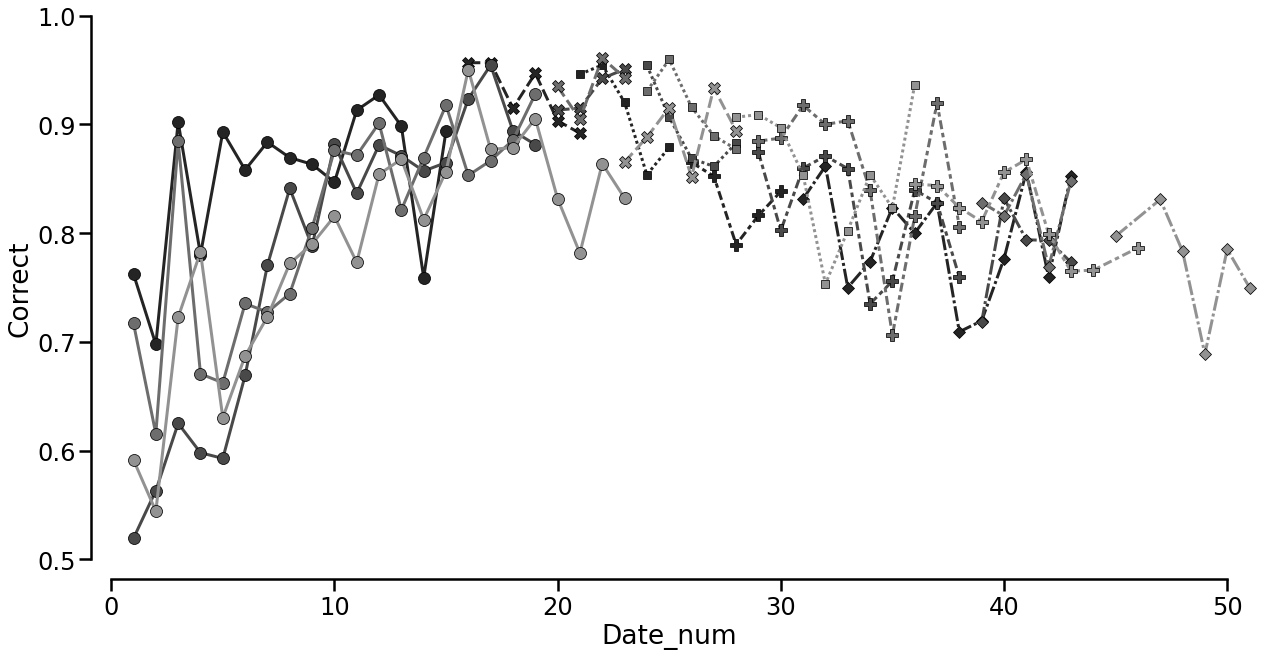

In [141]:
plt.figure(figsize=(20,10))

sns.lineplot(data=new_learning_df, x='Date_num', y='Correct', style='Window', hue='Animal', palette=sns.color_palette('gray'), errorbar=None, 
             legend=False, markeredgecolor='k', clip_on=False, markers=True) #ax=axes[1], 

plt.xlim(0,50)
plt.ylim(0.5,1)

sns.despine(offset=20)

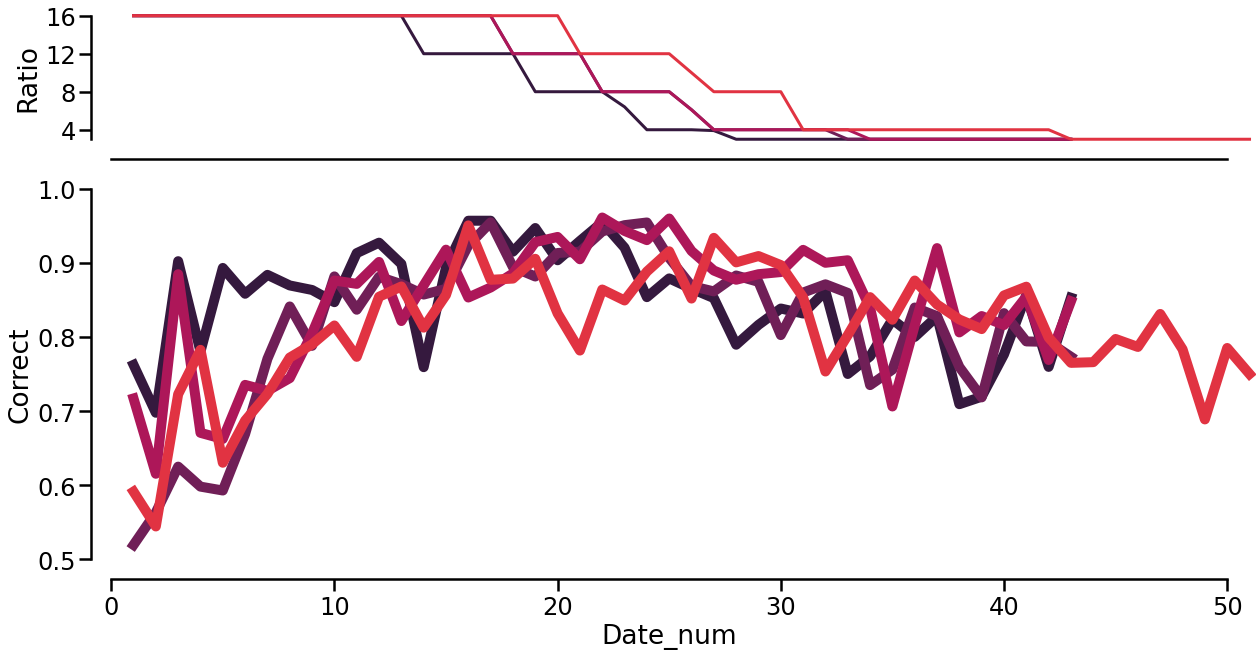

In [147]:
fig, axes = plt.subplots(2, 1, figsize=(20, 10), sharex=True, gridspec_kw={'height_ratios': [1, 3]})

sns.lineplot(data=new_learning_df, x='Date_num', y='Ratio', hue='Animal', 
             palette=sns.color_palette('rocket'), errorbar=None, ax=axes[0], color='k', clip_on=False, legend=False)

#axes[0].axvspan(0, 12, color="gray", alpha=0.2)   # sessions 1–4
axes[0].set_ylim(3,16)
axes[0].set_xlim(1,43)

axes[0].set_yticks([4,8,12,16])
axes[0].set_ylabel('Ratio')
# Remove top plot x-axis
#axes[0].set_xlabel("")
# Hide top plot x-axis completely
axes[0].tick_params(labelbottom=False, bottom=False)
axes[0].spines['bottom'].set_visible(False)
sns.lineplot(data=new_learning_df, x='Date_num', y='Correct', hue='Animal', palette=sns.color_palette('rocket'), errorbar=None, 
             legend=False, markeredgecolor='k', linewidth=10, clip_on=False)

plt.ylim(0.5,1)
plt.yticks([0.5,.6,.7,.8,.9,1])
plt.xlim(0,50)
plt.xticks([0,10,20,30,40,50])
sns.despine(offset=20)